# ADS 509 Text Mining Project

**Lorena Dorado & Parisa Kamizi** 

## Load and Explore the Dataset Structure

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import glob
import os
import html
import re
import json
import pickle
import logging
from datetime import datetime
from tqdm import tqdm
tqdm.pandas()

# Text processing
import textacy
import textacy.preprocessing as tprep
from textblob import TextBlob
from langdetect import detect

# Tokenization
import spacy
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex

# Feature Engineering
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation

# ML and Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Topic Modeling
from sklearn.decomposition import NMF, LatentDirichletAllocation
from wordcloud import WordCloud

In [2]:
# Setup logging
def setup_logging():
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler('text_mining.log'),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)

logger = setup_logging()
logger.info("Setup complete")

# Part 2: Data Loading
def load_news_data(directory='.'):
    """
    Load and combine multiple CSV files containing news data from a directory.
    """
    column_mapping = {
        'source_name': 'source',
        'publishedAt': 'date',
        'content': 'text',
        'title': 'title',
        'description': 'description'
    }
    
    csv_files = glob.glob(os.path.join(directory, '*.csv'))
    dfs = []
    
    for file in csv_files:
        try:
            temp_df = pd.read_csv(file)
            dfs.append(temp_df)
            logger.info(f"Successfully loaded {file}")
        except Exception as e:
            logger.error(f"Error reading file {file}: {str(e)}")
    
    if not dfs:
        raise ValueError("No CSV files were successfully loaded")
    
    combined_df = pd.concat(dfs, ignore_index=True)
    final_df = combined_df[column_mapping.keys()].rename(columns=column_mapping)
    
    # Convert date column to datetime
    final_df['date'] = pd.to_datetime(final_df['date'])
    
    # Basic cleaning
    for text_col in ['text', 'title', 'description']:
        final_df[text_col] = final_df[text_col].fillna('').str.strip()
    
    logger.info(f"Loaded {len(final_df)} rows from {len(csv_files)} files")
    return final_df

2025-02-14 01:02:19,712 - INFO - Setup complete


In [3]:
# Load the data
news_df = load_news_data()
print("\nDataset Info:")
print(news_df.info())
print("\nFirst few rows:")
print(news_df.head())

2025-02-14 01:02:19,728 - INFO - Successfully loaded .\Deepseek_Day_Five.csv
2025-02-14 01:02:19,728 - INFO - Successfully loaded .\Deepseek_Day_Four.csv
2025-02-14 01:02:19,743 - INFO - Successfully loaded .\Deepseek_Day_One.csv
2025-02-14 01:02:19,743 - INFO - Successfully loaded .\Deepseek_Day_Three.csv
2025-02-14 01:02:19,753 - INFO - Successfully loaded .\Deepseek_Day_Two.csv
2025-02-14 01:02:19,759 - INFO - Loaded 755 rows from 5 files



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755 entries, 0 to 754
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   source       570 non-null    object             
 1   date         570 non-null    datetime64[ns, UTC]
 2   text         755 non-null    object             
 3   title        755 non-null    object             
 4   description  755 non-null    object             
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 29.6+ KB
None

First few rows:
             source                      date  \
0       Gizmodo.com 2025-02-04 15:00:56+00:00   
1  Business Insider 2025-02-04 18:25:21+00:00   
2      Substack.com 2025-02-04 21:28:04+00:00   
3  Business Insider 2025-02-04 21:26:32+00:00   
4      heise online 2025-02-04 14:00:00+00:00   

                                                text  \
0  Usually when large language models are given t...   
1  Meta's

## Text Cleaning and Preprocessing

In [4]:
def clean_news_text(text):
    """Enhanced text cleaning function"""
    if not text or pd.isna(text):
        return ""
    
    # convert html escapes
    text = html.unescape(text)
    
    # Remove "[+XXX chars]" pattern
    text = re.sub(r'\[\+\d+ chars\]', '', text)
    
    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)
    
    # Clean special characters and encoding issues
    text = re.sub(r'â€™', "'", text)
    text = re.sub(r'â€"', "-", text)
    text = re.sub(r'[^\w\s\-\'.,!?]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

def detect_and_handle_language(text):
    """Detect language of text"""
    try:
        return detect(text)
    except:
        return 'unknown'

def remove_duplicates(df):
    """Remove duplicate articles based on content similarity"""
    df['text_signature'] = df['title'] + df['text'].str[:200]
    original_len = len(df)
    df = df.drop_duplicates(subset=['text_signature'])
    df = df.drop('text_signature', axis=1)
    logger.info(f"Removed {original_len - len(df)} duplicate articles")
    return df

In [5]:
# Apply text cleaning
news_df['clean_text'] = news_df['text'].progress_apply(clean_news_text)
news_df['language'] = news_df['clean_text'].progress_apply(detect_and_handle_language)
news_df = remove_duplicates(news_df)

print("\nCleaned Dataset Info:")
print(news_df.info())
print("\nLanguage distribution:")
print(news_df['language'].value_counts())

100%|███████████████████████████████████████████████████████████████████████████████| 755/755 [00:03<00:00, 196.88it/s]
2025-02-14 01:02:23,657 - INFO - Removed 286 duplicate articles



Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 469 entries, 0 to 568
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   source       468 non-null    object             
 1   date         468 non-null    datetime64[ns, UTC]
 2   text         469 non-null    object             
 3   title        469 non-null    object             
 4   description  469 non-null    object             
 5   clean_text   469 non-null    object             
 6   language     469 non-null    object             
dtypes: datetime64[ns, UTC](1), object(6)
memory usage: 29.3+ KB
None

Language distribution:
language
en         230
es          74
nl          58
de          32
it          19
pt          13
fr          13
vi           8
et           4
id           3
hu           3
so           2
pl           2
unknown      2
ro           2
tl           1
sk           1
lt           1
cs           1
Name

## Feature Engineering

In [6]:
def add_sentiment_features(df):
    """Add sentiment analysis features"""
    df['sentiment'] = df['text'].progress_apply(lambda x: TextBlob(x).sentiment.polarity)
    df['subjectivity'] = df['text'].progress_apply(lambda x: TextBlob(x).sentiment.subjectivity)
    return df

def create_news_vectorizer(min_df=2, max_df=0.95):
    """Create optimized vectorizer for news articles"""
    return CountVectorizer(
        stop_words='english',
        min_df=min_df, 
        max_df=max_df,
        ngram_range=(1, 2),
        token_pattern=r'\b\w+\b',
        strip_accents='unicode'
    )

def extract_topics(doc_term_matrix, n_topics=5, vectorizer=None):
    """Extract topics using LDA"""
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        max_iter=20
    )
    topic_matrix = lda.fit_transform(doc_term_matrix)
    
    if vectorizer:
        feature_names = vectorizer.get_feature_names_out()
        topic_words = []
        for topic_idx, topic in enumerate(lda.components_):
            top_words = [feature_names[i] for i in topic.argsort()[:-10:-1]]
            topic_words.append(top_words)
        return topic_matrix, topic_words
    
    return topic_matrix

In [7]:
# Apply feature engineering
news_df = add_sentiment_features(news_df)
vectorizer = create_news_vectorizer()
doc_term_matrix = vectorizer.fit_transform(news_df['clean_text'])
topic_matrix, topic_words = extract_topics(doc_term_matrix, vectorizer=vectorizer)

print("\nTopic Words:")
for idx, words in enumerate(topic_words):
    print(f"\nTopic {idx + 1}: {', '.join(words)}")

print("\nSentiment Statistics:")
print(news_df[['sentiment', 'subjectivity']].describe())

100%|██████████████████████████████████████████████████████████████████████████████| 469/469 [00:00<00:00, 2979.30it/s]



Topic Words:

Topic 1: deepseek, li, ai, s, r1, model, chinese, li li, openai

Topic 2: s, deepseek, access, store, li, getty, ai, use, including

Topic 3: deepseek, openai, ai, mini, o3, chatgpt, o3 mini, 1, 2

Topic 4: la, que, en, deepseek, el, y, ia, ha, una

Topic 5: ai, deepseek, 2025, 02, 01, id, 2025 02, nvidia, 02 01

Sentiment Statistics:
        sentiment  subjectivity
count  469.000000    469.000000
mean    -0.007080      0.272173
std      0.223259      0.316011
min     -0.900000      0.000000
25%      0.000000      0.000000
50%      0.000000      0.200000
75%      0.033333      0.466667
max      1.000000      1.000000


In [8]:
# Remove rows with empty/NaN sources
news_df = news_df.dropna(subset=['source'])

# Double check there are no more NaN sources
print("Number of NaN sources after cleaning:", news_df['source'].isna().sum())

Number of NaN sources after cleaning: 0


## Classification

In [9]:
class NewsClassifier:
    def __init__(self):
        self.tfidf = TfidfVectorizer(
            min_df=5,  # Increased from 10 to include more terms
            max_df=0.9,  # Increased from default to include more terms
            ngram_range=(1, 2),
            stop_words="english"
        )
        
        # Use balanced class weights and adjusted parameters
        self.classifiers = {
            'svm': SVC(
                kernel="linear",
                C=1,
                probability=True,
                random_state=42,
                class_weight='balanced'  # Add class weight balancing
            ),
        }
        self.ensemble = None
        self.min_samples_per_class = 3  # Minimum samples required per class
        
    def prepare_data(self, df):
        """Prepare news articles for classification with filtering"""
        # Combine text fields
        df['combined_text'] = (
            df['title'].fillna('') * 2 + ' ' +
            df['description'].fillna('') + ' ' +
            df['text'].fillna('')
        )
        
        # Count samples per class
        class_counts = df['source'].value_counts()
        
        # Filter for classes with sufficient samples
        valid_classes = class_counts[class_counts >= self.min_samples_per_class].index
        df_filtered = df[df['source'].isin(valid_classes)].copy()
        
        if len(df_filtered) < len(df):
            logger.info(f"Filtered out {len(df) - len(df_filtered)} samples from rare classes")
        
        return df_filtered
    
    def create_ensemble(self):
        """Create ensemble classifier"""
        estimators = [(name, clf) for name, clf in self.classifiers.items()]
        self.ensemble = VotingClassifier(estimators=estimators, voting='soft')
        return self.ensemble
    
    def train_and_evaluate(self, df, target_column='source', use_ensemble=False):
        """Train model and evaluate performance"""
        # Prepare and filter data
        df = self.prepare_data(df)
        
        if len(df) == 0:
            raise ValueError("No samples remaining after filtering")
        
        # Time-based split
        train_df, test_df = self.temporal_split(df)
        
        X_train = train_df['combined_text']
        y_train = train_df[target_column]
        X_test = test_df['combined_text']
        y_test = test_df[target_column]
        
        # Transform features
        X_train_tfidf = self.tfidf.fit_transform(X_train)
        X_test_tfidf = self.tfidf.transform(X_test)
        
        # Train and evaluate
        if use_ensemble:
            classifier = self.create_ensemble()
        else:
            classifier = self.classifiers['svm']
        
        # Adjust cross-validation based on class sizes
        n_splits = min(5, min(np.bincount(pd.factorize(y_train)[0])))
        if n_splits < 2:
            logger.warning("Not enough samples for cross-validation")
            cv_scores = {'mean': None, 'std': None}
        else:
            cv_scores = cross_val_score(classifier, X_train_tfidf, y_train, cv=n_splits)
            cv_scores = {
                'mean': float(cv_scores.mean()),
                'std': float(cv_scores.std())
            }
        
        # Final training
        classifier.fit(X_train_tfidf, y_train)
        y_pred = classifier.predict(X_test_tfidf)
        
        # Calculate metrics
        results = {
            'accuracy': float(accuracy_score(y_test, y_pred)),
            'classification_report': classification_report(
                y_test, 
                y_pred, 
                zero_division=0,  # Handle zero division
                output_dict=True  # Return as dict for JSON serialization
            ),
            'confusion_matrix': confusion_matrix(y_test, y_pred).tolist(),  # Convert to list for JSON
            'cv_scores': cv_scores,
            'test_data': {
                'X_test': list(X_test),
                'y_test': list(y_test),
                'y_pred': list(y_pred)
            },
            'classes': list(classifier.classes_)
        }
        
        self.save_model_version(classifier, results)
        return results
    
    def temporal_split(self, df, train_ratio=0.8):
        """Split data temporally"""
        df = df.sort_values('date')
        train_end = df['date'].quantile(train_ratio)
        
        train_df = df[df['date'] <= train_end]
        test_df = df[df['date'] > train_end]
        
        return train_df, test_df
    
    def get_classification_report_df(self, results):
        """Convert classification report to a formatted DataFrame"""
        report_df = pd.DataFrame(results['classification_report']).T
        
        # Reorder columns
        report_df = report_df[['precision', 'recall', 'f1-score', 'support']]
        
        # Round numeric columns
        report_df = report_df.round(3)
        
        # Convert support to integer
        report_df['support'] = report_df['support'].fillna(0).astype(int)
        
        return report_df

    def save_model_version(self, classifier, metrics):
        """Save model and metrics"""
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        os.makedirs('models', exist_ok=True)
        
        model_path = f'models/classifier_{timestamp}.pkl'
        with open(model_path, 'wb') as f:
            pickle.dump(classifier, f)
        
        metrics_path = f'models/metrics_{timestamp}.json'
        with open(metrics_path, 'w') as f:
            json.dump(metrics, f, indent=2)
        
        logger.info(f"Saved model and metrics to {model_path} and {metrics_path}")

# Function to analyze class distribution
def analyze_class_distribution(df, column='source'):
    """Analyze and print class distribution"""
    class_dist = df[column].value_counts()
    print("\nClass Distribution:")
    print(class_dist)
    
    print("\nNumber of classes:", len(class_dist))
    print("Min samples in a class:", class_dist.min())
    print("Max samples in a class:", class_dist.max())
    
    return class_dist

2025-02-14 01:02:25,362 - INFO - Filtered out 147 samples from rare classes
2025-02-14 01:02:25,415 - WARNING - Not enough samples for cross-validation



Class Distribution:
source
Business Insider       33
Xataka.com             30
Yahoo Entertainment    25
Forbes                 20
Genbeta.com            12
                       ..
Macsparky.com           1
Iphoneitalia.com        1
Digiday                 1
Basicthinking.de        1
Weeraman.com            1
Name: count, Length: 154, dtype: int64

Number of classes: 154
Min samples in a class: 1
Max samples in a class: 33


2025-02-14 01:02:25,619 - INFO - Saved model and metrics to models/classifier_20250214_010225.pkl and models/metrics_20250214_010225.json



Classification Results:
Accuracy: 0.281

Detailed Report:

Classification Metrics by Class:
                              precision  recall  f1-score  support
3dnews.ru                         0.000   0.000     0.000        4
Android Central                   0.000   0.000     0.000        2
BBC News                          0.000   0.000     0.000        1
Biztoc.com                        0.000   0.000     0.000        3
Business Insider                  0.154   1.000     0.267        4
Cnblogs.com                       0.000   0.000     0.000        0
Faz.net                           0.000   0.000     0.000        4
Forbes                            0.200   0.167     0.182        6
Frandroid                         0.000   0.000     0.000        2
Geekpark.net                      0.000   0.000     0.000        2
Gizmodo.com                       0.000   0.000     0.000        1
Hdblog.it                         0.000   0.000     0.000        1
Himasoku.com                      1.

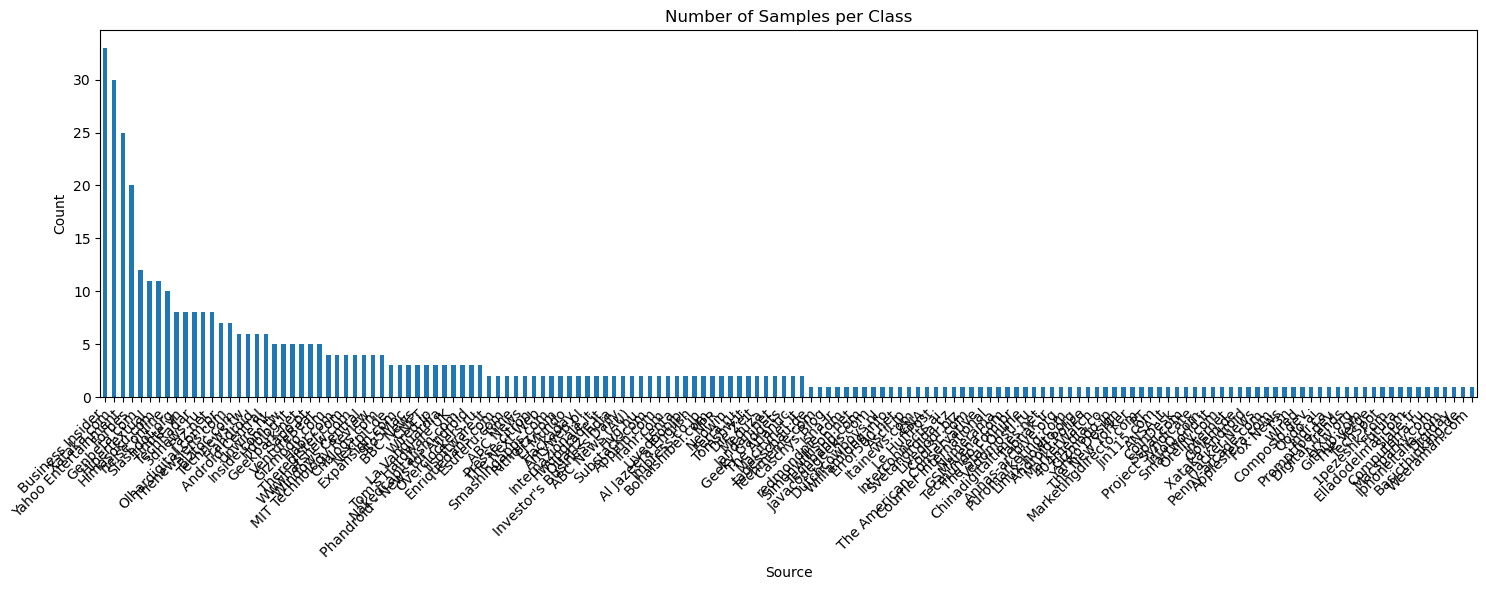

In [10]:
# First analyze the class distribution
class_dist = analyze_class_distribution(news_df)

# Then train and evaluate the classifier
classifier = NewsClassifier()
results = classifier.train_and_evaluate(news_df, use_ensemble=True)

print("\nClassification Results:")
print(f"Accuracy: {results['accuracy']:.3f}")
print("\nDetailed Report:")
# Convert classification report to DataFrame
report_df = pd.DataFrame(results['classification_report']).T
# Reorder columns for better readability
report_df = report_df[['precision', 'recall', 'f1-score', 'support']]
# Round numeric columns
report_df = report_df.round(3)
# Convert support to integer
report_df['support'] = report_df['support'].fillna(0).astype(int)
print("\nClassification Metrics by Class:")
print(report_df)

# Plot class distribution
plt.figure(figsize=(15, 6))
class_dist.plot(kind='bar')
plt.title('Number of Samples per Class')
plt.xlabel('Source')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Visualization

In [11]:
def plot_confusion_matrix(cm, labels, figsize=(15, 15)):
    cm = np.array(cm)
    
    # Sort labels by number of samples
    sample_counts = np.sum(cm, axis=1)
    sorted_indices = np.argsort(sample_counts)[::-1]  # Sort in descending order
    
    # Take top N sources
    top_n = 10
    indices = sorted_indices[:top_n]
    
    # Filter confusion matrix and labels
    filtered_cm = cm[indices][:, indices]
    filtered_labels = [labels[i] for i in indices]
    
    # Create normalized matrix with handling for zero division
    row_sums = np.sum(filtered_cm, axis=1)
    # Create a mask for zero rows
    zero_rows = row_sums == 0
    # Add small epsilon to zero rows to avoid division by zero
    row_sums[zero_rows] = 1  # Set to 1 to effectively show all zeros in that row
    normalized_cm = filtered_cm.astype('float') / row_sums[:, np.newaxis]
    # Zero out rows that were originally all zeros
    normalized_cm[zero_rows] = 0
    
    # Plot two heatmaps side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Raw counts
    sns.heatmap(filtered_cm, 
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=filtered_labels,
                yticklabels=filtered_labels,
                square=True,
                ax=ax1)
    
    # Normalized values
    sns.heatmap(normalized_cm,
                annot=True,
                fmt='.2f',
                cmap='Blues',
                xticklabels=filtered_labels,
                yticklabels=filtered_labels,
                square=True,
                ax=ax2)
    
    # Customize both subplots
    for ax in [ax1, ax2]:
        # Rotate labels for better readability
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    # Set titles
    ax1.set_title('Confusion Matrix (Counts)', pad=20)
    ax2.set_title('Confusion Matrix (Normalized)', pad=20)
    
    # Add common labels
    fig.text(0.5, 0.02, 'Predicted Label', ha='center', va='center')
    fig.text(0.02, 0.5, 'True Label', ha='center', va='center', rotation=90)
    
    # Adjust layout
    plt.tight_layout()
    
    return plt

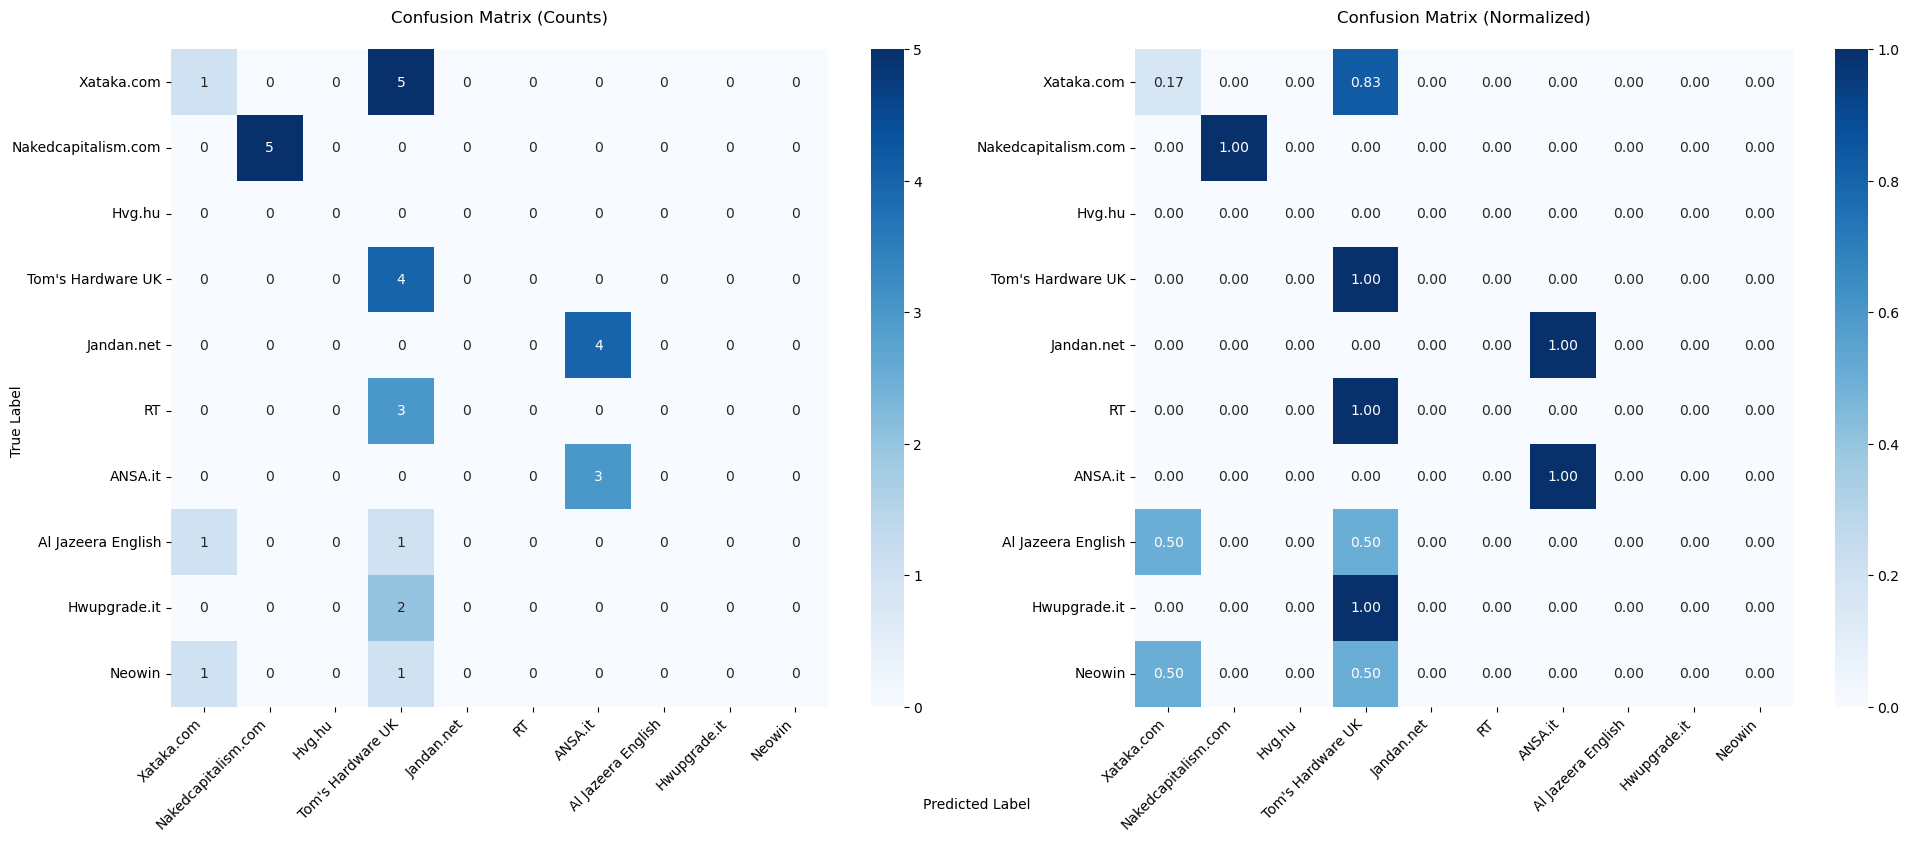


Source Distribution:
source
Business Insider       33
Xataka.com             30
Yahoo Entertainment    25
Forbes                 20
Genbeta.com            12
Hipertextual           11
Himasoku.com           11
heise online           10
Slashdot.org            8
Tinhte.vn               8
Name: count, dtype: int64


In [12]:
## display visualizations
cm = results['confusion_matrix']
labels = list(set(news_df['source']))

# Plot both raw and normalized confusion matrices
plot_confusion_matrix(cm, labels)
plt.show()

# Print source distribution
print("\nSource Distribution:")
source_counts = news_df['source'].value_counts()
print(source_counts.head(10))  # Show top 10 sources

In [13]:

def plot_sentiment_distribution(df):
    """Plot sentiment distribution"""
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x='sentiment', bins=50)
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Count')
    plt.tight_layout()
    return plt

def plot_topic_evolution(topic_matrix, dates, n_topics=5):
    """Plot topic evolution over time"""
    topic_shares = pd.DataFrame(topic_matrix)
    topic_shares['date'] = dates
    topic_shares = topic_shares.set_index('date')
    
    # Resample to weekly averages
    weekly_shares = topic_shares.resample('W').mean()
    
    plt.figure(figsize=(15, 8))
    for i in range(n_topics):
        plt.plot(weekly_shares.index, weekly_shares[i], label=f'Topic {i+1}')
    
    plt.title('Topic Evolution Over Time')
    plt.xlabel('Date')
    plt.ylabel('Topic Share')
    plt.legend()
    plt.tight_layout()
    return plt

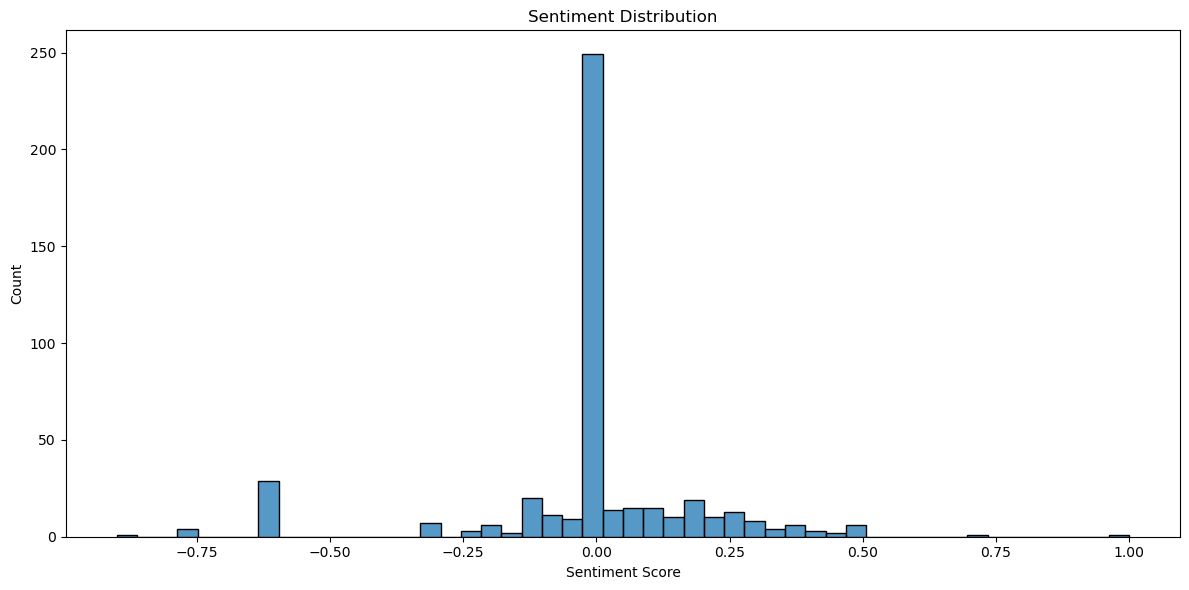

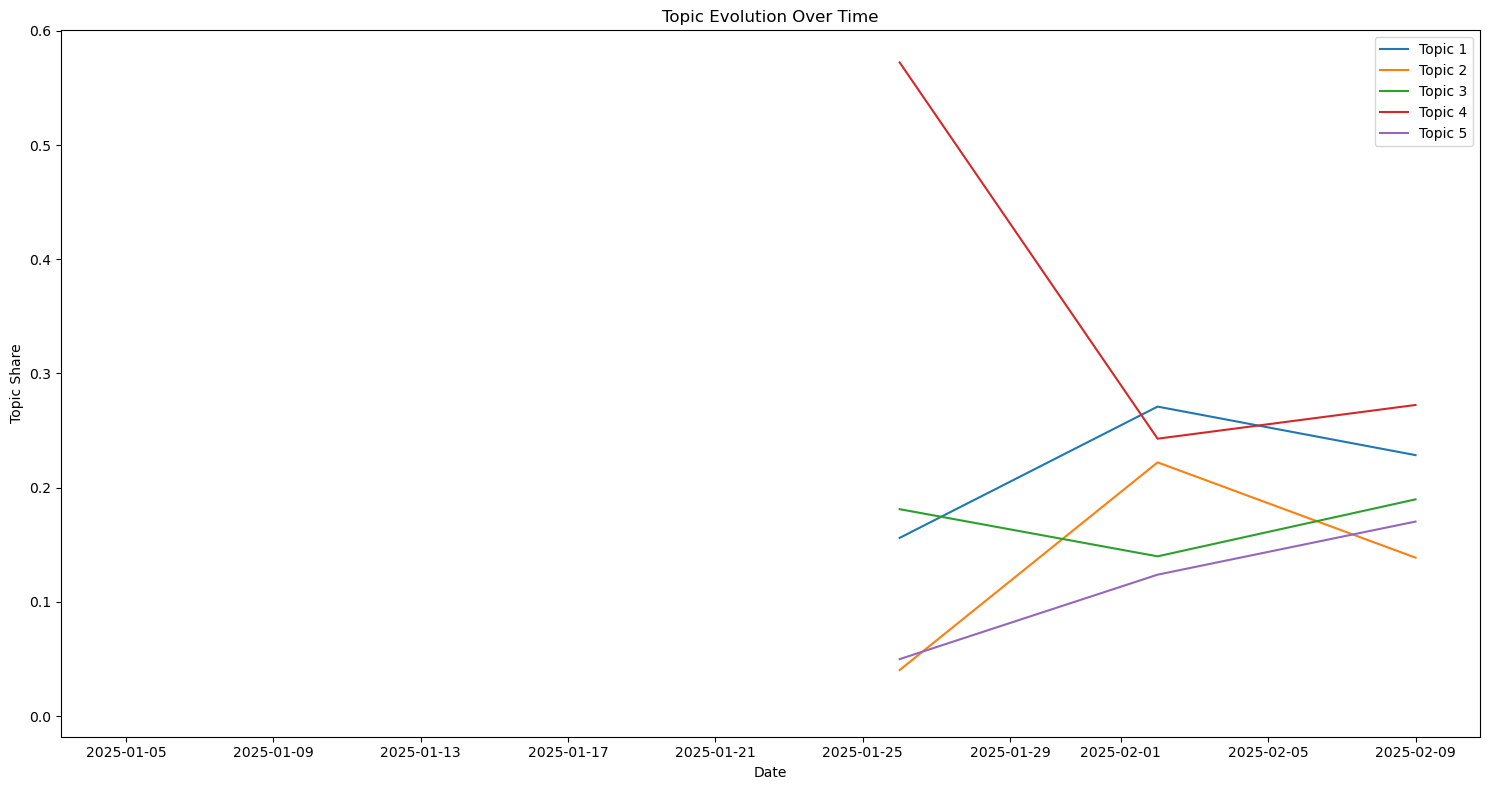

2025-02-14 01:02:28,306 - INFO - Analysis complete. Check visualizations and results.


In [14]:
plot_sentiment_distribution(news_df)
plt.show()

plot_topic_evolution(topic_matrix, news_df['date'])
plt.show()

logger.info("Analysis complete. Check visualizations and results.")

## Topic Modeling

In [15]:
class TopicModeling:
    def __init__(self, n_topics=10, random_state=42):
        self.n_topics = n_topics
        self.random_state = random_state
        
        # Initialize vectorizers
        self.tfidf_vectorizer = TfidfVectorizer(
            max_df=0.7,
            min_df=5,
            stop_words='english'
        )
        
        self.count_vectorizer = CountVectorizer(
            max_df=0.7,
            min_df=5,
            stop_words='english'
        )
        
        # Initialize models
        self.nmf_model = NMF(
            n_components=n_topics,
            random_state=random_state,
            max_iter=1000
        )
        
        self.lda_model = LatentDirichletAllocation(
            n_components=n_topics,
            random_state=random_state,
            max_iter=20
        )

In [16]:
def preprocess_and_vectorize(self, texts):
    """Vectorize texts using both TF-IDF and Count vectorizers"""
    self.tfidf_matrix = self.tfidf_vectorizer.fit_transform(texts)
    self.count_matrix = self.count_vectorizer.fit_transform(texts)
    
    return self.tfidf_matrix, self.count_matrix

TopicModeling.preprocess_and_vectorize = preprocess_and_vectorize

In [17]:
def fit_models(self):
    """Fit both NMF and LDA models"""
    # Fit NMF with TF-IDF
    self.nmf_topics = self.nmf_model.fit_transform(self.tfidf_matrix)
    
    # Fit LDA with Count vectors
    self.lda_topics = self.lda_model.fit_transform(self.count_matrix)
    
    return self.nmf_topics, self.lda_topics

TopicModeling.fit_models = fit_models

In [18]:
def display_topics(self, model, feature_names, n_top_words=10):
    """Display top words for each topic"""
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append({
            'topic': topic_idx,
            'words': top_words,
            'weights': sorted(topic[topic.argsort()[:-n_top_words - 1:-1]], reverse=True)
        })
    return topics

TopicModeling.display_topics = display_topics

In [19]:
def visualize_topics(self, model, feature_names, title):
    """Create heatmap visualization of topic-word distributions"""
    plt.figure(figsize=(20, 10))
    topics = self.display_topics(model, feature_names)
    
    # Create word-weight matrix for visualization
    word_weight_matrix = np.zeros((self.n_topics, 10))  # 10 top words
    word_labels = []
    
    for i, topic in enumerate(topics):
        word_weight_matrix[i] = topic['weights']
        if i == 0:
            word_labels = topic['words']
    
    # Create heatmap
    sns.heatmap(word_weight_matrix, 
               xticklabels=word_labels,
               yticklabels=[f'Topic {i+1}' for i in range(self.n_topics)],
               cmap='YlOrRd')
    
    plt.title(title)
    plt.xlabel('Top Words')
    plt.ylabel('Topics')
    plt.tight_layout()
    return plt

TopicModeling.visualize_topics = visualize_topics

In [20]:
def create_wordclouds(self, model, feature_names):
    """Generate wordclouds for each topic"""
    for topic_idx, topic in enumerate(model.components_):
        # Create dictionary of word frequencies
        word_freq = dict(zip(feature_names, topic))
        
        # Generate wordcloud
        wordcloud = WordCloud(
            background_color='white',
            width=800,
            height=400
        ).generate_from_frequencies(word_freq)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Topic {topic_idx + 1}')
        plt.show()

TopicModeling.create_wordclouds = create_wordclouds

In [21]:
def analyze_topic_distribution(self, dates=None):
    """Analyze topic distribution over time if dates are provided"""
    if dates is not None:
        # Convert topics to DataFrame with dates
        nmf_df = pd.DataFrame(self.nmf_topics)
        nmf_df['date'] = pd.to_datetime(dates)
        nmf_df = nmf_df.set_index('date')
        
        # Resample to monthly averages
        monthly_avg = nmf_df.resample('M').mean()
        
        # Plot topic evolution
        plt.figure(figsize=(15, 8))
        for i in range(self.n_topics):
            plt.plot(monthly_avg.index, monthly_avg[i], label=f'Topic {i+1}')
        
        plt.title('Topic Evolution Over Time')
        plt.xlabel('Date')
        plt.ylabel('Topic Strength')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        return plt

TopicModeling.analyze_topic_distribution = analyze_topic_distribution

In [22]:
def analyze_news_topics(news_df, n_topics=10):
    # Initialize topic modeling
    topic_model = TopicModeling(n_topics=n_topics)
    
    # Preprocess and vectorize
    tfidf_matrix, count_matrix = topic_model.preprocess_and_vectorize(news_df['clean_text'])
    
    # Fit models
    nmf_topics, lda_topics = topic_model.fit_models()
    
    # Get feature names
    tfidf_features = topic_model.tfidf_vectorizer.get_feature_names_out()
    count_features = topic_model.count_vectorizer.get_feature_names_out()
    
    # Display topics
    print("NMF Topics:")
    nmf_topic_words = topic_model.display_topics(topic_model.nmf_model, tfidf_features)
    for topic in nmf_topic_words:
        print(f"\nTopic {topic['topic'] + 1}:")
        print(", ".join(topic['words']))
    
    print("\nLDA Topics:")
    lda_topic_words = topic_model.display_topics(topic_model.lda_model, count_features)
    for topic in lda_topic_words:
        print(f"\nTopic {topic['topic'] + 1}:")
        print(", ".join(topic['words']))
    
    # Visualize topics
    topic_model.visualize_topics(topic_model.nmf_model, tfidf_features, "NMF Topic-Word Distribution")
    plt.show()
    
    topic_model.visualize_topics(topic_model.lda_model, count_features, "LDA Topic-Word Distribution")
    plt.show()
    
    # Generate wordclouds
    print("\nGenerating NMF Wordclouds:")
    topic_model.create_wordclouds(topic_model.nmf_model, tfidf_features)
    
    # Analyze topic evolution over time
    topic_model.analyze_topic_distribution(news_df['date'])
    plt.show()
    
    return topic_model, nmf_topics, lda_topics

In [23]:
# Create an instance of the TopicModeling class
topic_model = TopicModeling(n_topics=10)

tfidf_matrix, count_matrix = topic_model.preprocess_and_vectorize(news_df['clean_text'])

In [24]:
nmf_topics, lda_topics = topic_model.fit_models()

#### NMF Topics


Topic 1:
deepseek, r1, chatgpt, nvidia, v3, bloomberg, flyer, gpu, high, llm

Topic 2:
la, en, que, el, los, ia, ha, es, inteligencia, una

Topic 3:
framework, words, accept, consent, click, partners, iab, transparency, 239, access

Topic 4:
li, ul, images, getty, ol, r1, models, need, apple, business

Topic 5:
chinese, model, new, tech, startup, week, intelligence, artificial, open, monday

Topic 6:
2025, 02, 01, id, 10, 31, 48, 22, 20, 43

Topic 7:
openai, o3, mini, chatgpt, altman, sam, o1, google, api, reddit

Topic 8:
die, der, ki, das, und, hat, für, von, den, eine

Topic 9:
ai, meta, industry, latest, deepseekdeepseek, content, company, impact, generative, leading

Topic 10:
di, il, da, artificiale, che, intelligenza, le, ha, del, modello


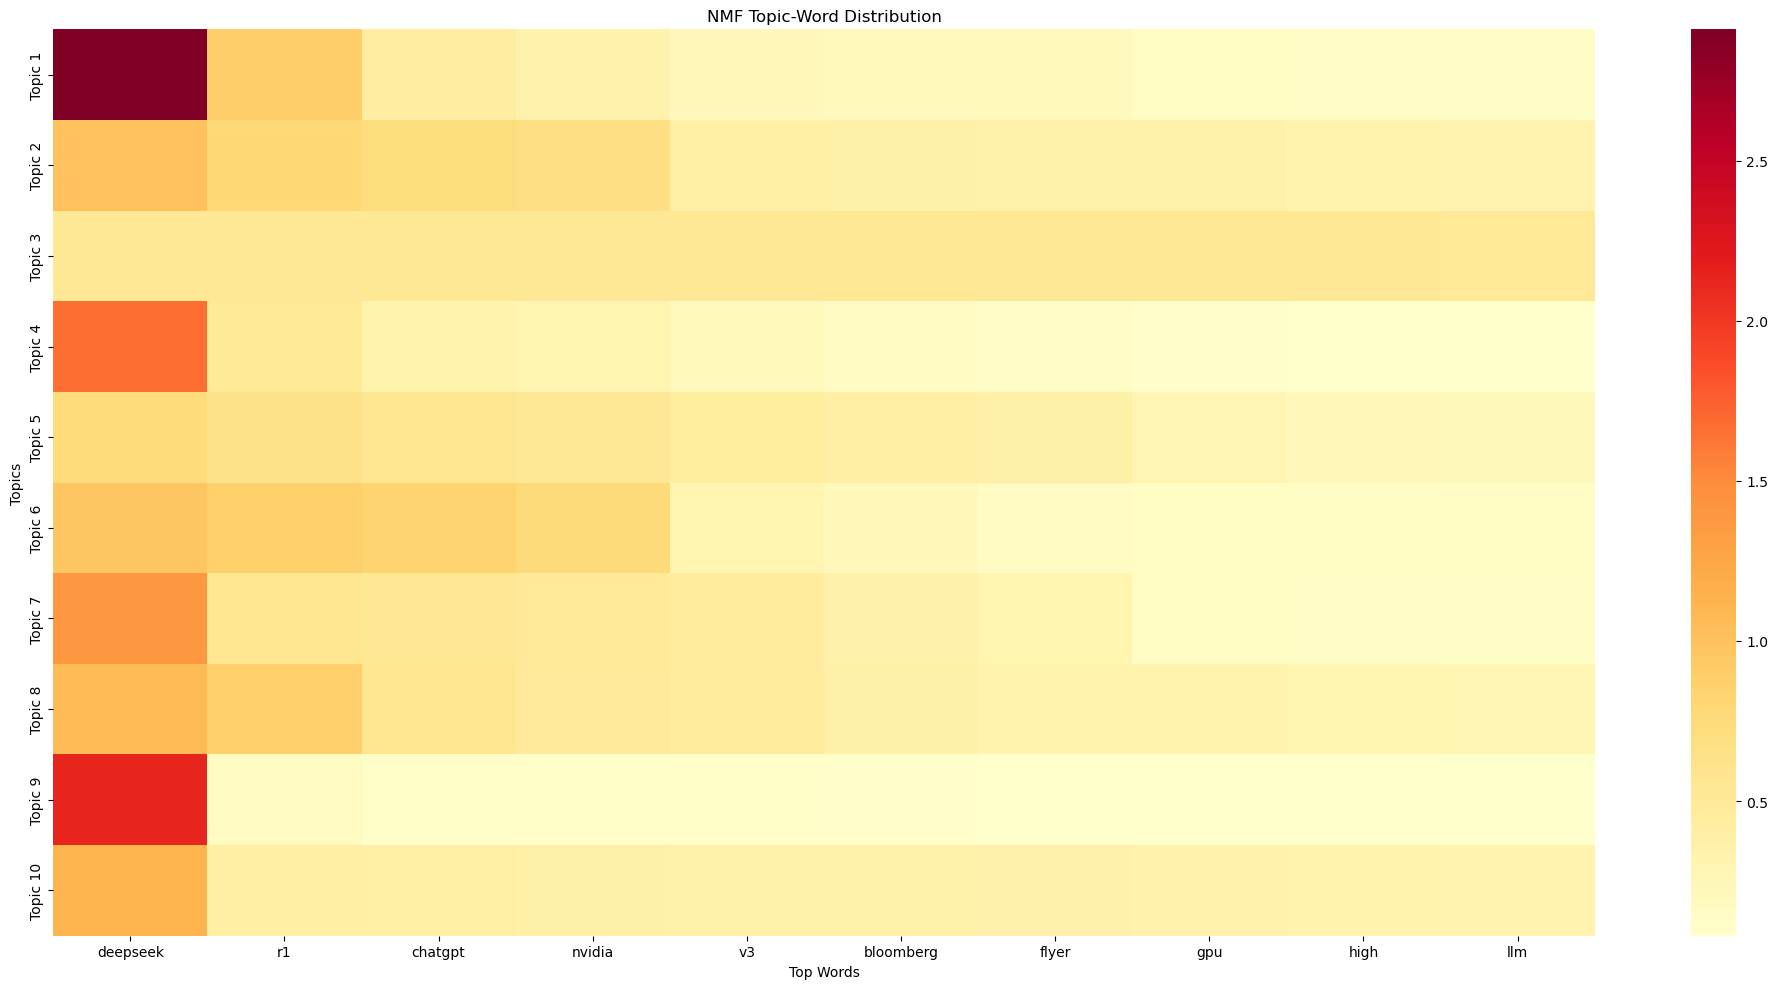

In [25]:
# Topics
tfidf_features = topic_model.tfidf_vectorizer.get_feature_names_out()
nmf_topics_words = topic_model.display_topics(topic_model.nmf_model, tfidf_features)
for topic in nmf_topics_words:
    print(f"\nTopic {topic['topic'] + 1}:")
    print(", ".join(topic['words']))
    
# Heatmap
topic_model.visualize_topics(topic_model.nmf_model, tfidf_features, "NMF Topic-Word Distribution")
plt.show()

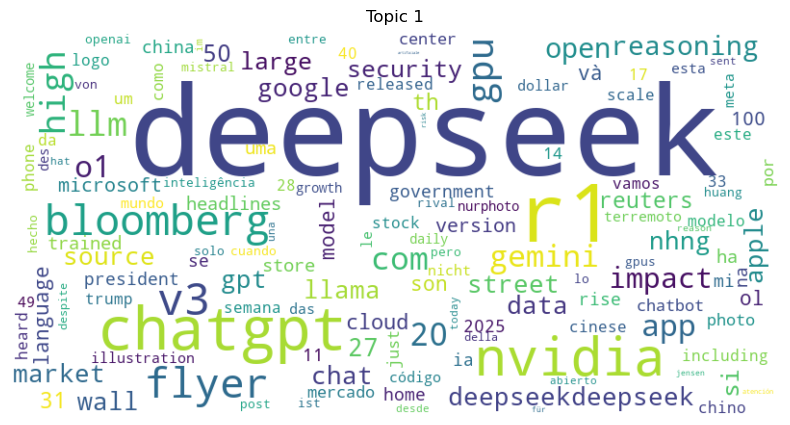

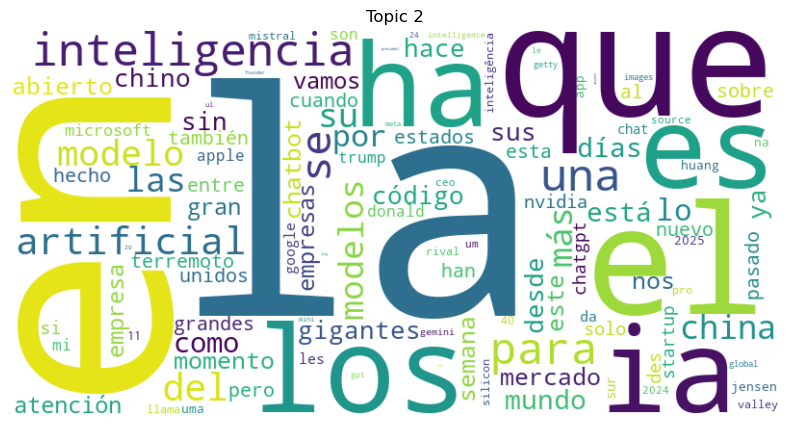

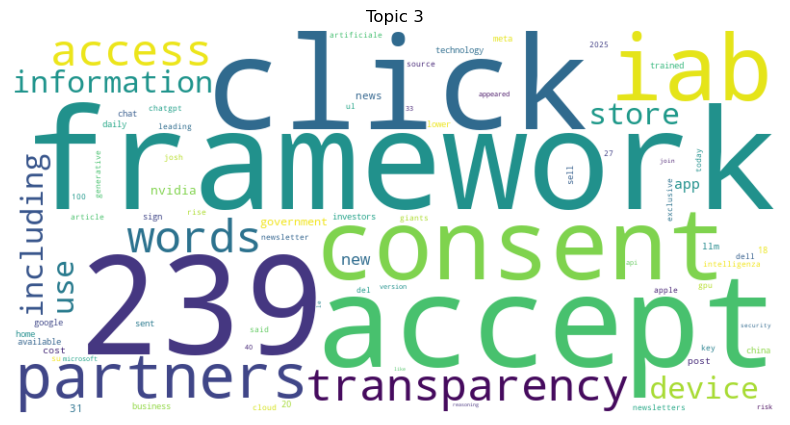

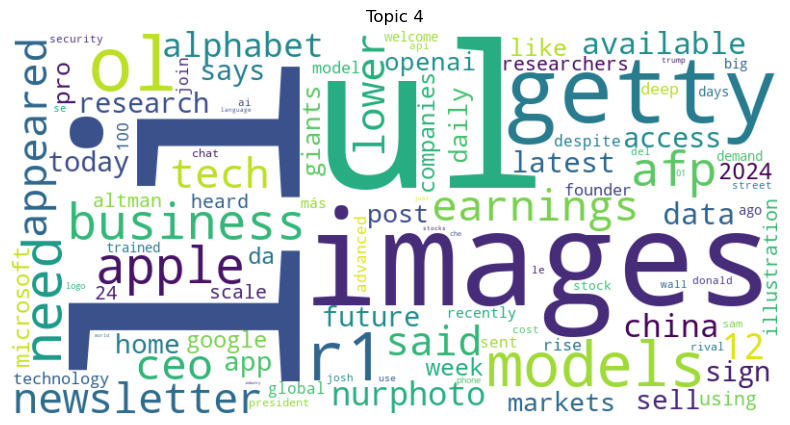

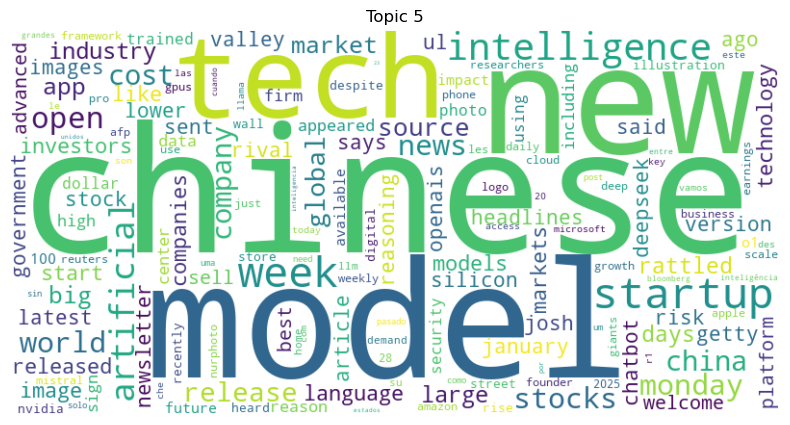

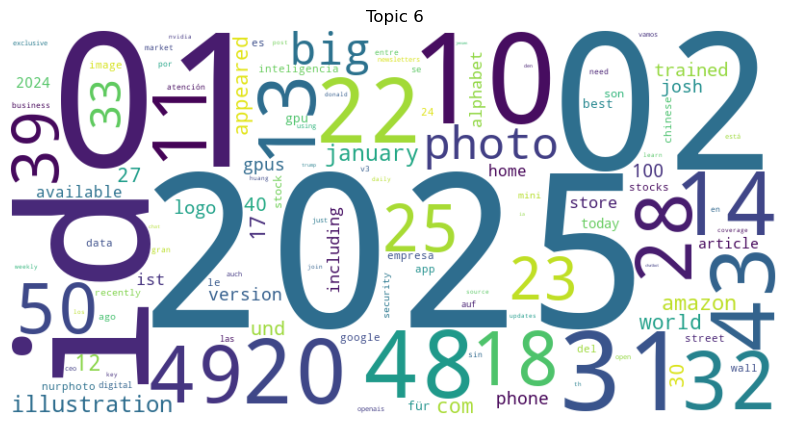

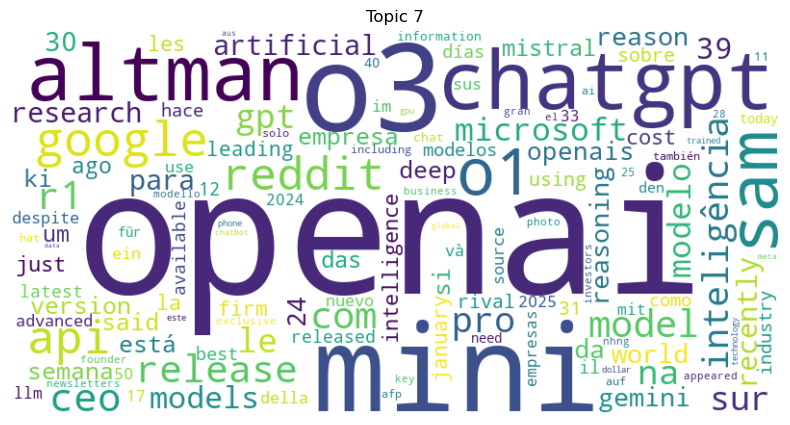

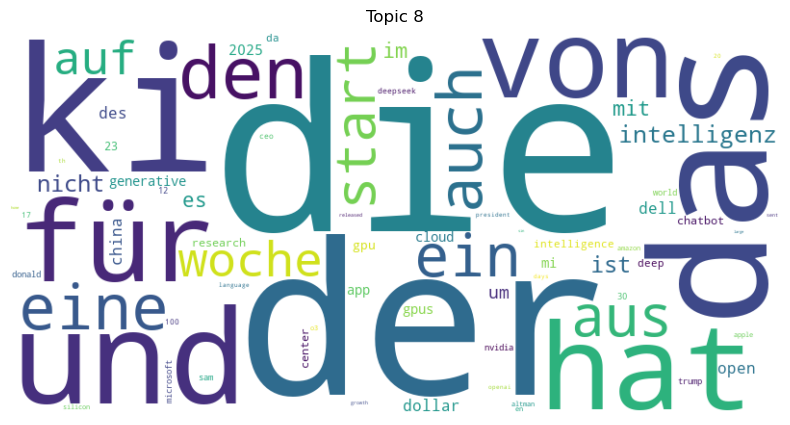

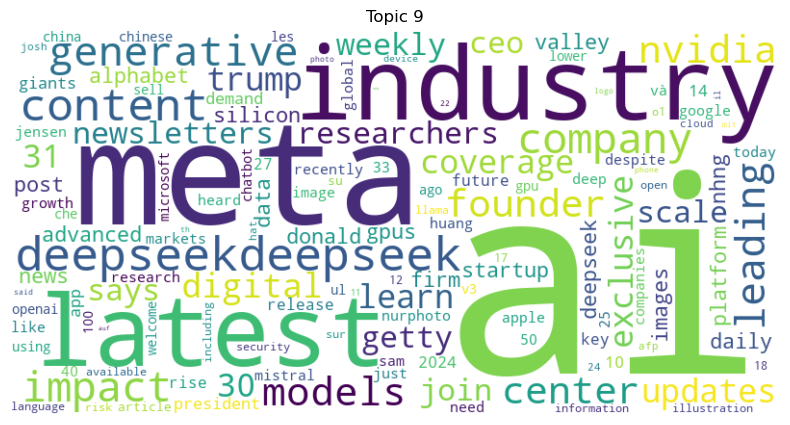

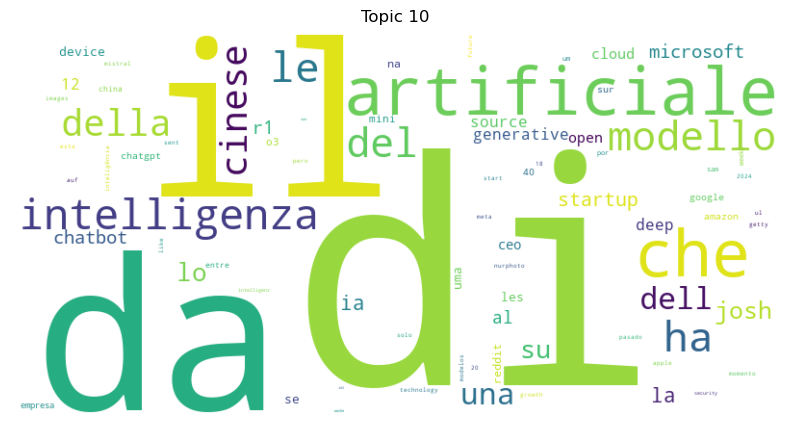

In [26]:
topic_model.create_wordclouds(topic_model.nmf_model, tfidf_features)

#### LDA Topics


Topic 1:
más, google, hace, pero, mit, nuevo, intelligenz, se, lo, im

Topic 2:
deepseek, nvidia, ai, chinese, intelligence, app, week, tech, artificial, trump

Topic 3:
ai, deepseek, meta, open, v3, openai, alphabet, mi, 2024, says

Topic 4:
2025, 01, 02, id, 10, 31, photo, 20, 28, illustration

Topic 5:
la, en, que, el, ia, ha, artificial, los, deepseek, una

Topic 6:
deepseek, model, di, r1, le, open, source, large, da, ha

Topic 7:
deepseek, openai, chatgpt, r1, mini, o3, altman, sam, o1, pro

Topic 8:
ai, deepseek, new, industry, company, release, leading, latest, cost, content

Topic 9:
li, deepseek, ai, ul, getty, images, tech, chinese, ol, r1

Topic 10:
die, der, use, access, including, information, framework, device, store, partners


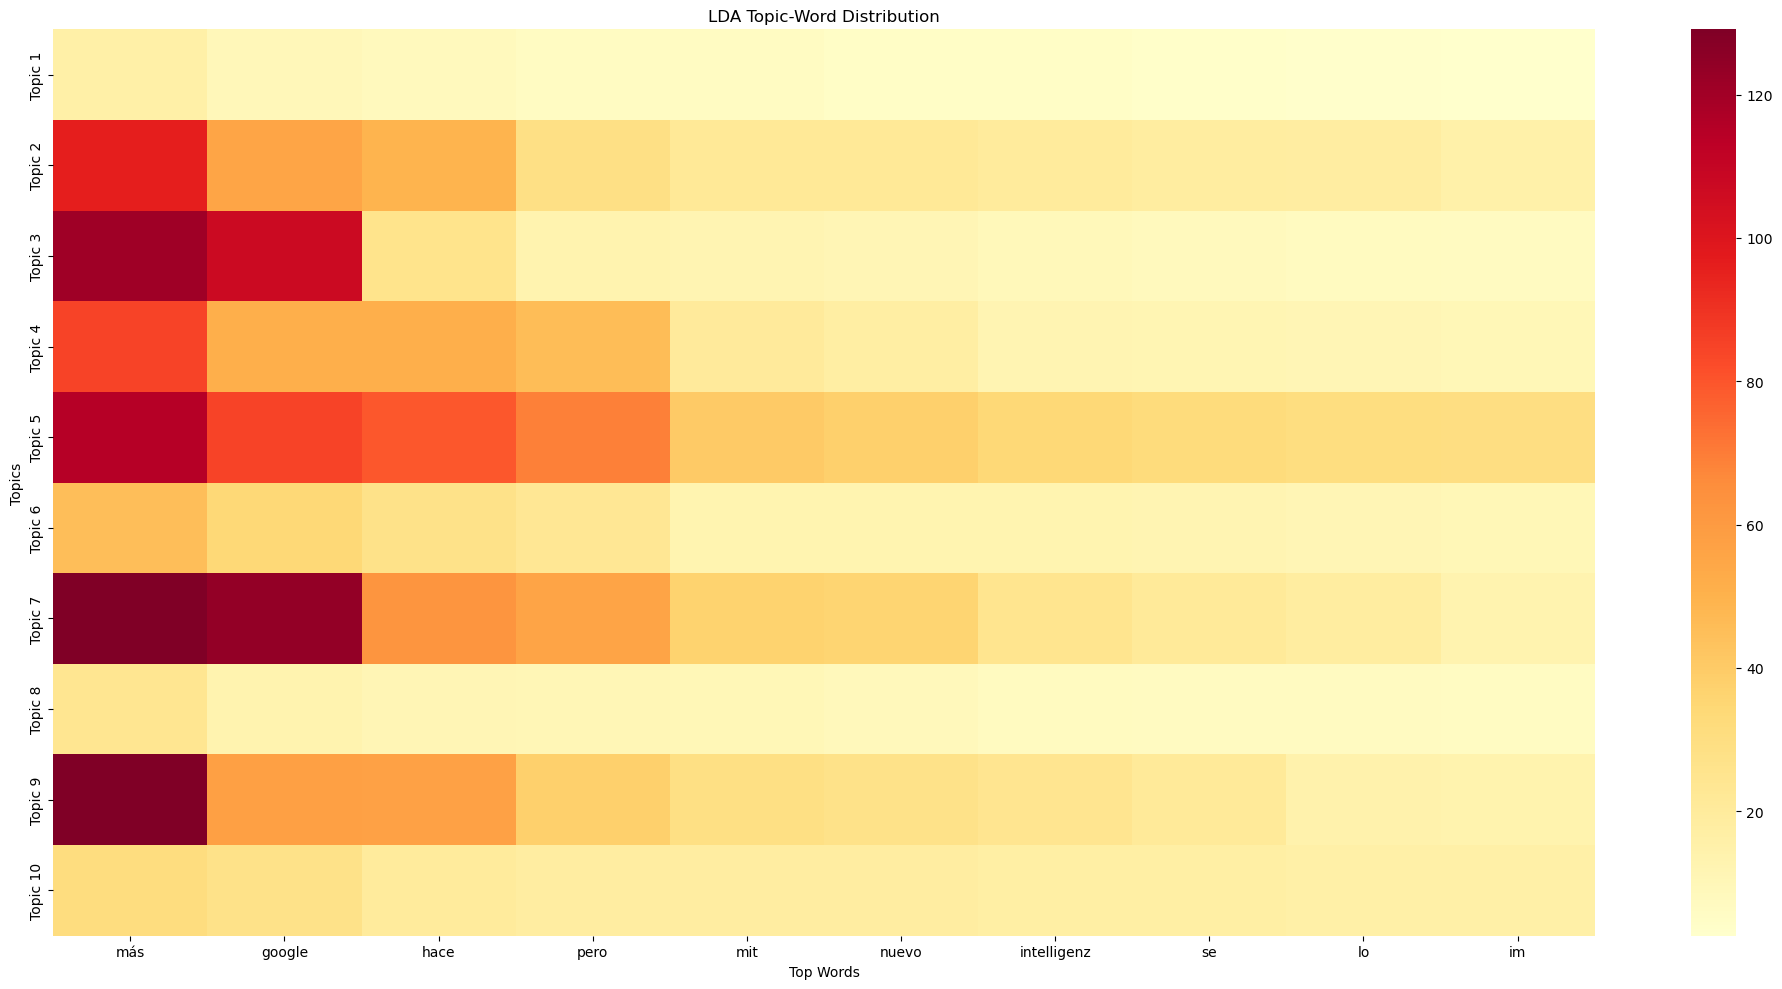

In [27]:
# Topics
count_features = topic_model.count_vectorizer.get_feature_names_out()
lda_topics_words = topic_model.display_topics(topic_model.lda_model, count_features)
for topic in lda_topics_words:
    print(f"\nTopic {topic['topic'] + 1}:")
    print(", ".join(topic['words']))
    
# Heatmap
topic_model.visualize_topics(topic_model.lda_model, count_features, "LDA Topic-Word Distribution")
plt.show()

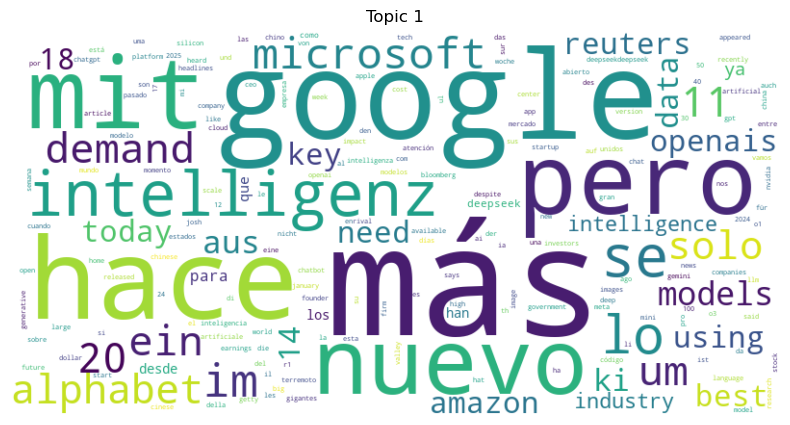

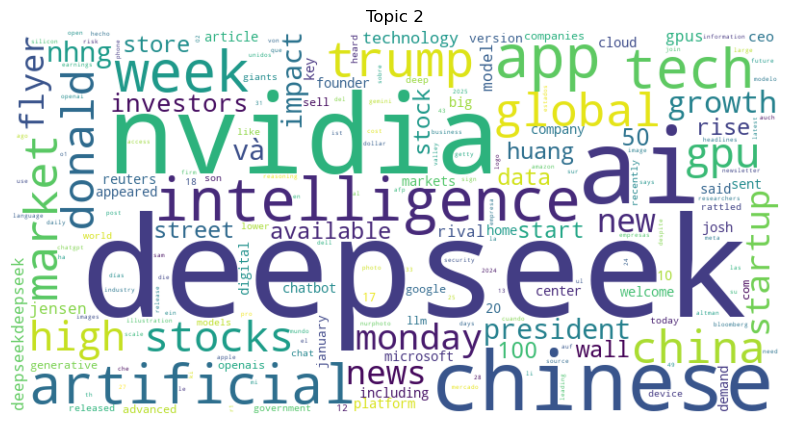

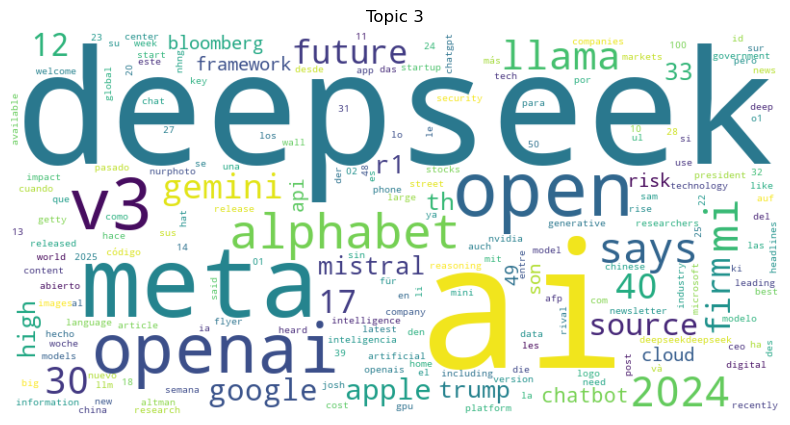

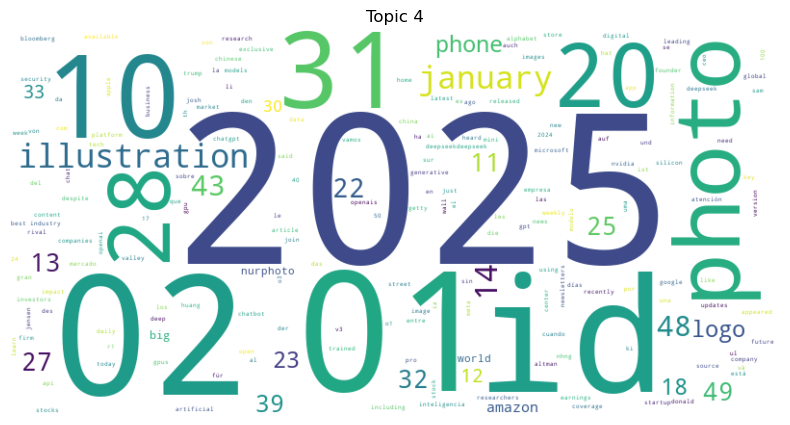

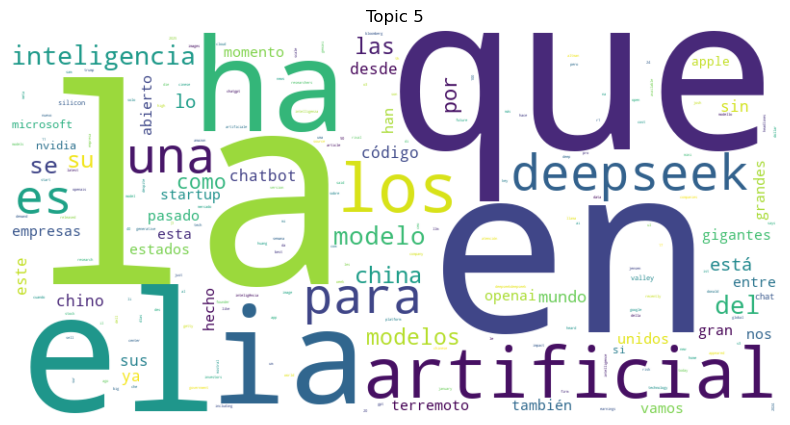

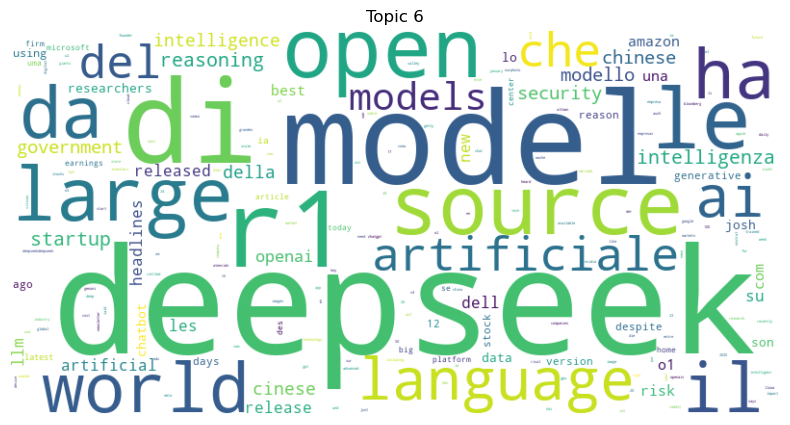

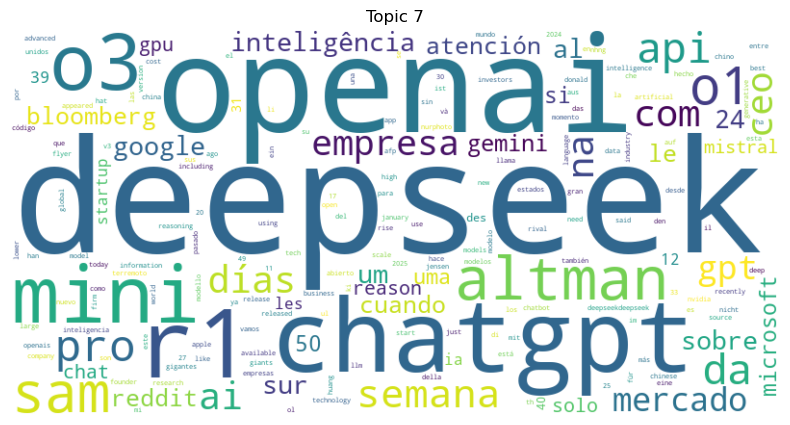

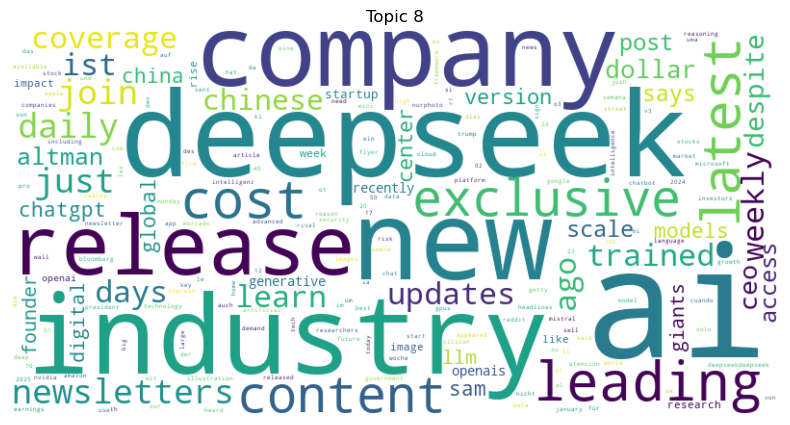

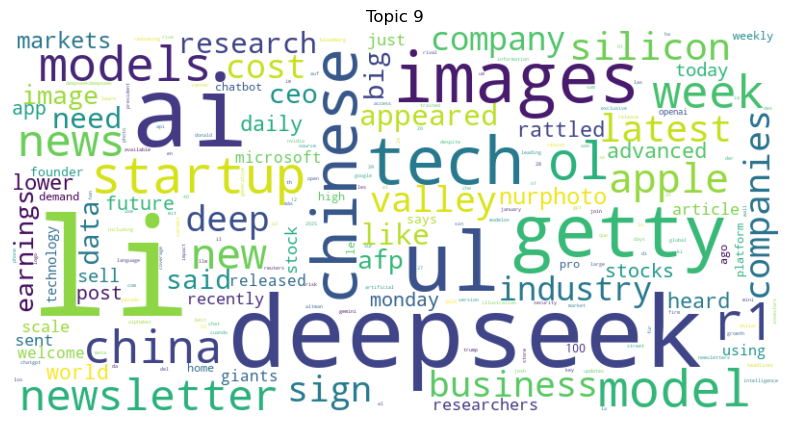

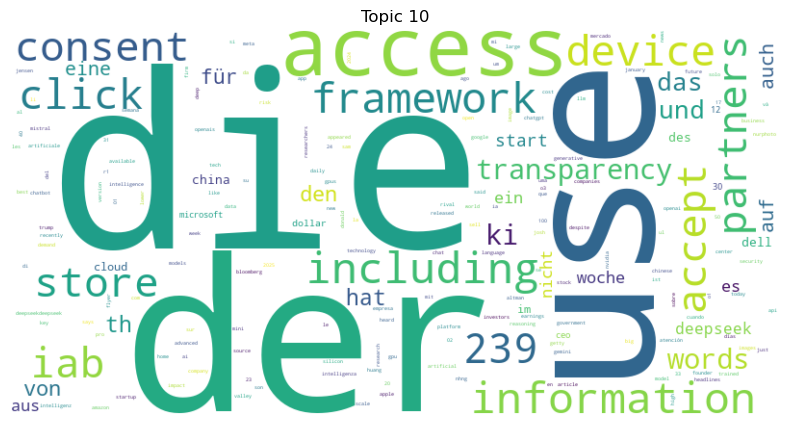

In [28]:
topic_model.create_wordclouds(topic_model.lda_model, count_features)

**References**

Albrecht, J., Ramachandran, S., & Winkler, C. (2020). Blueprints for text analytics using Python: Machine learning-based solutions for common real-world (NLP) applications [GitHub repository]. O’Reilly. https://github.com/blueprints-for-text-analytics-python/blueprints-text/tree/master

OpenAI. (2025). ChatGPT (Feb 13 version) [Large language model]. https://openai.com